## Burger's Equation
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (0,1),\ t\in(0,1] 
\end{equation}
We set $\nu=0.1$ and consider the periodic boundary condition here, i.e.:
$$
u(x-\pi, t) = u(x+\pi, t),\quad t\in(0,1]
$$
The initial condition is $u(x,t=0)=a(x)$. Our goal is to learn a neural operator to predict the solution $u$ at $t=1$ given an initial condition $a(x)$, i.e.:
$$
\mathcal{G}: a(x) \rightarrow u(x,t=1)
$$

## (2) The MultiONet method (Cartesian)

### (2.1) Prepare data

<KeysViewHDF5 ['t_mesh', 'u0', 'u_sol', 'x_mesh']>
<KeysViewHDF5 ['t_mesh', 'u0', 'u_sol', 'x_mesh']>
The shape of a_train: torch.Size([1000, 128])
The shape of uT_train: torch.Size([1000, 128, 1])
The shape of gridx_train: torch.Size([128, 1])
The shape of a_test: torch.Size([50, 128])
The shape of uT_train: torch.Size([50, 128, 1])
The shape of gridx_test: torch.Size([128, 1])


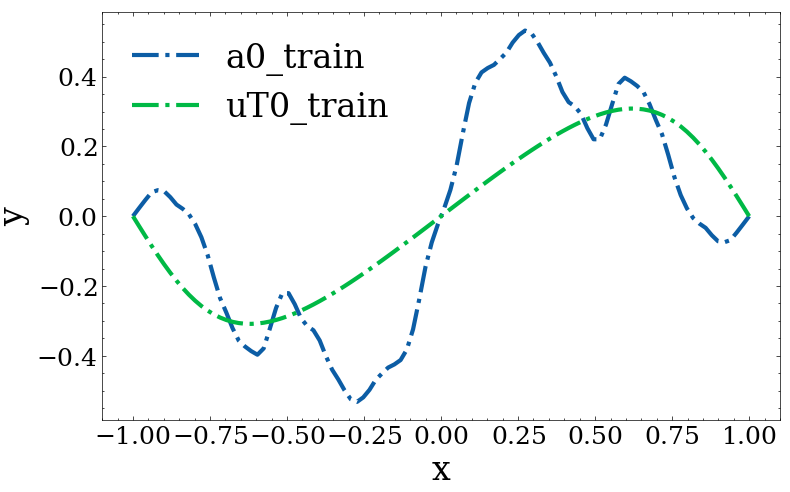

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Burgers_1d'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/Burgers_1d/viscid_train.mat', 'r')
data_test = h5py.File('../../Problems/Burgers_1d/viscid_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
######################################
# Load training data
######################################
from Utils.utils import *
n_train, n_test = 1000, 50
def get_data(data, ndata, dtype, n0=0):
    # Data is of the shape (number of samples = 1000, grid size = 29*29)
    a = np2tensor(np.array(data["u0"][...,n0:n0+ndata]).T, dtype)
    u = np2tensor(np.array(data["u_sol"][...,n0:n0+ndata]).T, dtype)
    uT = u[:,-1,:]
    #
    x_mesh = np2tensor(np.array(data['x_mesh']))
    #
    a = a.reshape(ndata, -1)
    uT = uT.reshape(ndata, -1, 1)
    
    return a, uT, x_mesh
#
a_train, uT_train, gridx_train = get_data(data_train, n_train, dtype)
a_test, uT_test, gridx_test = get_data(data_test, n_test, dtype)
#
print('The shape of a_train:', a_train.shape)
print('The shape of uT_train:', uT_train.shape)
print('The shape of gridx_train:', gridx_train.shape)
#
print('The shape of a_test:', a_test.shape)
print('The shape of uT_train:', uT_test.shape)
print('The shape of gridx_test:', gridx_test.shape)
########################################
from Utils.PlotFigure import Plot
inx = 5
#
Plot.show_1d_list(gridx_train, [a_train[inx], uT_train[inx]], ['a0_train', 'uT0_train'], lb =-1.)

### (2.2) Define the loss class

In [2]:
###############################
# Set normalizer
###############################
from sklearn.preprocessing import StandardScaler

class Normalizer_a(object):

    def __init__(self, scale:float=0.1, shift:float=0.75):
        self.scale = scale
        self.shift = shift
        
    def encode(self, a:torch.tensor):
        '''
        Input: 
            a: (n_batch, n_mesh) 
        '''
        return a * self.scale - self.shift
        
    def decode(self, a:torch.tensor):
        '''
        Input: 
            a: (n_batch, n_mesh)
        '''
        return (a+self.shift)*self.scale
#
normalizer_a = Normalizer_a(1., 0.)

###############################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        ''' '''
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.model_u = solver.model_dict['u']

    def Loss_data(self, a, u, x_grid):
        ''' '''
        a_norm = normalizer_a.encode(a)
        u_pred = self.model_u(x_grid, a_norm)
        #
        loss = self.solver.getLoss(u_pred, u)
        
        return loss

    def Error(self, a, u, x_grid):
        ''' '''
        a_norm = normalizer_a.encode(a)
        u_pred = self.model_u(x_grid, a_norm)
        #
        err = self.solver.getError(u_pred, u)
        
        return err

######################################
# Steups of the model
######################################
from Solvers.MultiONet import MultiONet
solver = MultiONet.Solver(device, dtype)
netType = 'MultiONetCartesian'
#
hidden_list, act_x, act_a = [128]*3, 'Tanh_Sin', 'Tanh_Sin'
model_u = solver.getModel(x_in_size=1, a_in_size=128, hidden_list=hidden_list, 
                          activation_x=act_x, activation_a=act_a, netType='Cartesian')
# ###############################
from torchsummary import summary
summary(model_u, [(1,), (128,)], device='cpu')
# ###############################
total_params = sum(p.numel() for p in model_u.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params_u = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params_u:,} training parameters.')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             256
          Tanh_Sin-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
          Tanh_Sin-4                  [-1, 128]               0
            Linear-5                  [-1, 128]          16,512
          Tanh_Sin-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
          Tanh_Sin-8                  [-1, 128]               0
            Linear-9                  [-1, 128]          16,512
         Tanh_Sin-10                  [-1, 128]               0
           Linear-11                  [-1, 128]          16,512
         Tanh_Sin-12                  [-1, 128]               0
           Linear-13                  [-1, 128]          16,512
         Tanh_Sin-14                  [

### (2.3) Training and making prediction

#### (2.3.1) Training 

In [3]:
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR', step_size=500)
solver.train_cartesian(LossClass, a_train, uT_train, gridx_train, a_test, uT_test, gridx_test, 
                       batch_size=50, epochs=2000, epoch_show=100, **{'save_path':f'saved_models/{netType}/'})

  5%|██▍                                             | 101/2000 [00:10<03:18,  9.58it/s]

Epoch:100 Time:10.2759, loss_train:0.099773, loss_test:0.099066
          lr: 0.001 err_test 0.07253453880548477


 10%|████▊                                           | 201/2000 [00:20<03:05,  9.69it/s]

Epoch:200 Time:20.6457, loss_train:0.078715, loss_test:0.071611
          lr: 0.001 err_test 0.06294959783554077


 15%|███████▏                                        | 301/2000 [00:30<02:01, 13.93it/s]

Epoch:300 Time:30.7234, loss_train:0.075292, loss_test:0.052196
          lr: 0.001 err_test 0.04186221957206726


 20%|█████████▋                                      | 403/2000 [00:37<01:43, 15.49it/s]

Epoch:400 Time:37.2962, loss_train:0.053552, loss_test:0.060673
          lr: 0.001 err_test 0.0436389334499836


 25%|████████████                                    | 501/2000 [00:43<01:39, 15.07it/s]

Epoch:500 Time:43.8329, loss_train:0.049871, loss_test:0.041456
          lr: 0.0005 err_test 0.03775447979569435


 30%|██████████████▍                                 | 603/2000 [00:50<01:30, 15.45it/s]

Epoch:600 Time:50.3703, loss_train:0.024228, loss_test:0.028211
          lr: 0.0005 err_test 0.023540420457720757


 35%|████████████████▊                               | 703/2000 [00:57<01:24, 15.29it/s]

Epoch:700 Time:56.8573, loss_train:0.025359, loss_test:0.025768
          lr: 0.0005 err_test 0.016844922676682472


 40%|███████████████████▎                            | 803/2000 [01:03<01:17, 15.48it/s]

Epoch:800 Time:63.3760, loss_train:0.026238, loss_test:0.021378
          lr: 0.0005 err_test 0.01749337837100029


 45%|█████████████████████▋                          | 903/2000 [01:10<01:11, 15.34it/s]

Epoch:900 Time:69.9535, loss_train:0.024068, loss_test:0.025501
          lr: 0.0005 err_test 0.017846787348389626


 50%|███████████████████████▌                       | 1001/2000 [01:16<01:07, 14.81it/s]

Epoch:1000 Time:76.5228, loss_train:0.020074, loss_test:0.023771
          lr: 0.00025 err_test 0.015811484307050705


 55%|█████████████████████████▉                     | 1103/2000 [01:23<00:57, 15.54it/s]

Epoch:1100 Time:83.0805, loss_train:0.013758, loss_test:0.013636
          lr: 0.00025 err_test 0.009814834222197533


 60%|████████████████████████████▎                  | 1203/2000 [01:29<00:51, 15.51it/s]

Epoch:1200 Time:89.5531, loss_train:0.013905, loss_test:0.014133
          lr: 0.00025 err_test 0.0094110993668437


 65%|██████████████████████████████▌                | 1303/2000 [01:36<00:45, 15.42it/s]

Epoch:1300 Time:96.0500, loss_train:0.014999, loss_test:0.013125
          lr: 0.00025 err_test 0.010703069157898426


 70%|████████████████████████████████▉              | 1403/2000 [01:42<00:38, 15.47it/s]

Epoch:1400 Time:102.5305, loss_train:0.014130, loss_test:0.017698
          lr: 0.00025 err_test 0.011322077363729477


 75%|███████████████████████████████████▎           | 1503/2000 [01:49<00:32, 15.34it/s]

Epoch:1500 Time:108.9837, loss_train:0.013753, loss_test:0.011167
          lr: 0.000125 err_test 0.0082086231559515


 80%|█████████████████████████████████████▋         | 1603/2000 [01:55<00:25, 15.66it/s]

Epoch:1600 Time:115.5303, loss_train:0.007883, loss_test:0.006710
          lr: 0.000125 err_test 0.005314993672072887


 85%|████████████████████████████████████████       | 1703/2000 [02:02<00:19, 15.37it/s]

Epoch:1700 Time:122.0297, loss_train:0.008792, loss_test:0.009770
          lr: 0.000125 err_test 0.00803267303854227


 90%|██████████████████████████████████████████▎    | 1803/2000 [02:08<00:12, 15.89it/s]

Epoch:1800 Time:128.4057, loss_train:0.008959, loss_test:0.007353
          lr: 0.000125 err_test 0.005777874495834112


 95%|████████████████████████████████████████████▋  | 1903/2000 [02:14<00:06, 15.81it/s]

Epoch:1900 Time:134.7016, loss_train:0.008031, loss_test:0.007683
          lr: 0.000125 err_test 0.005878787022083998


100%|███████████████████████████████████████████████| 2000/2000 [02:21<00:00, 14.18it/s]

Epoch:2000 Time:141.0197, loss_train:0.006614, loss_test:0.006931
          lr: 6.25e-05 err_test 0.004995936062186956
The total training time is 141.0240


### (3) load saved model and make prediction

The shape of a_test: torch.Size([50, 128])
The shape of uT_test: torch.Size([50, 128, 1])
The test loss tensor(0.0069)
The test l2 error: tensor(0.0050)
*************************************
The test l2 error for 0: tensor(0.0104)
The test l2 error for 1: tensor(0.0025)
The test l2 error for 2: tensor(0.0011)
The test l2 error for 3: tensor(0.0031)
The test l2 error for 4: tensor(0.0030)


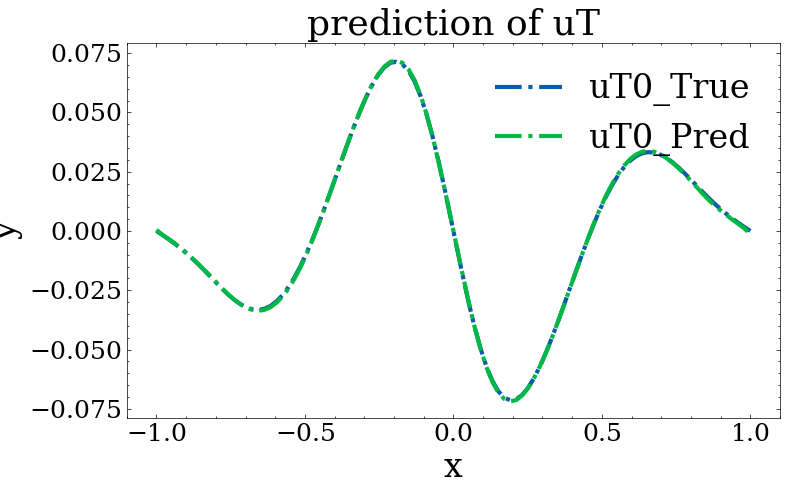

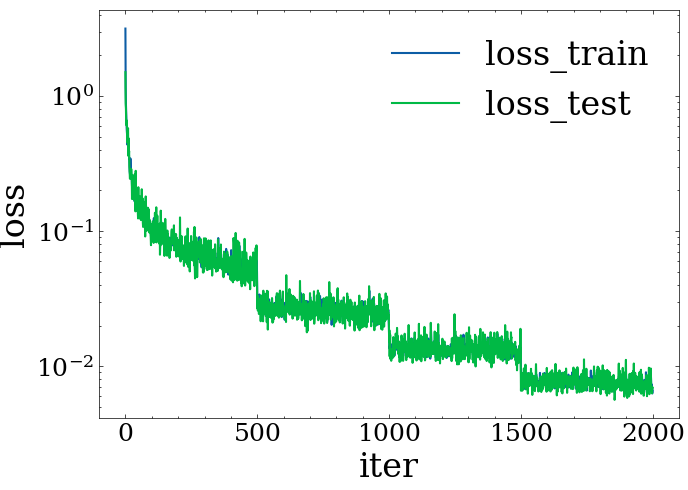

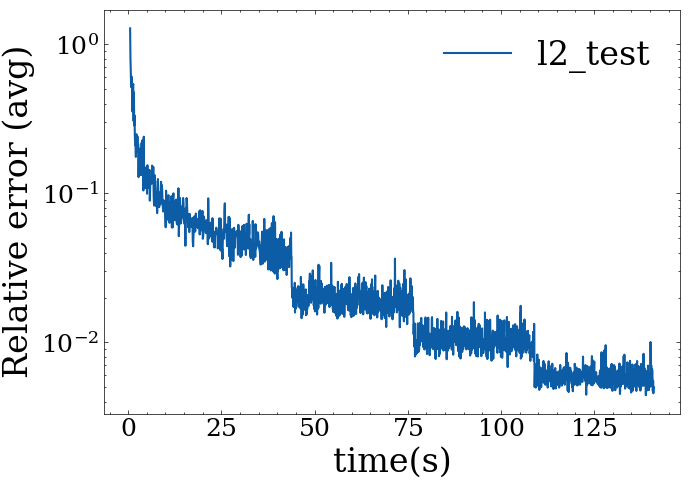

In [3]:
#####################################
# Load the trained model
#####################################
from Solvers.MultiONet import MultiONet
solver = MultiONet.Solver(device, dtype)
model_trained = solver.loadModel(path=f'saved_models/{netType}/', name='model_multionet_final')

#########################################
with torch.no_grad():
    a = normalizer_a.encode(a_test.to(device))
    uT_pred = model_trained['u'](gridx_test.to(device), a)
    uT_pred = uT_pred.detach().cpu()
#
print('The shape of a_test:', a_test.shape)
print('The shape of uT_test:', uT_test.shape)
print('The test loss', solver.getLoss(uT_pred, uT_test))
print('The test l2 error:', solver.getError(uT_pred, uT_test))
print('*************************************')
for i in range(0, 5):
    print(f'The test l2 error for {i}:', solver.getError(uT_pred[i:i+1], uT_test[i:i+1]))
inx = 0
# ########################################
from Utils.PlotFigure import Plot
# show prediction
Plot.show_1d_list(gridx_test, [uT_test[inx], uT_pred[inx]], 
                  label_list=['uT0_True', 'uT0_Pred'], title='prediction of uT')
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/{netType}/', name='loss_multionet')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test']], ['loss_train', 'loss_test'])
# show error
Plot.show_error([loss_saved['time']], [loss_saved['l2_test']], ['l2_test'])